In [1]:
from scipy.optimize import nnls
import numpy as np

In [2]:
def power_law_nl(x, a = 1, b = 2):
    return a * x**b

def power_law_inv(y, a = 1, b = 2):
    return (y / a)**(1/b)

In [3]:
#load data (.mat)
import scipy.io as sio
data = sio.loadmat('../../data/Data_cell_types_small_size.mat')

In [4]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

Is = data['contrast']

# SBI

In [5]:
import torch

#from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### define simulator and prior

In [6]:
#prior
from scipy.stats import expon


prior = [torch.distributions.Exponential(torch.tensor([4.0]))]*24


In [7]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\sbi\utils\user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 24 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


### e and pv

In [19]:
import torch
import numpy as np

# Assuming data and power_law_nl are defined elsewhere

def simulator2(wb):
    # Define inputs
    i = 0
    max_it = 3000
    
    delta_t = 0.05
    r = torch.rand(24)  # Initialize r with shape (4, 6)
    I_values = data['contrast'][0][:6]/torch.tensor([100])  # Get the 6 different I values

    while i < max_it:
        
        for j, I in enumerate(I_values):
            A_1 = torch.tensor([r[j*4], -1 * r[j*4 +1], -1 *r[j*4 +2], -1 * r[j*4+3], I, 1])
            A_2 = torch.tensor([r[j*4], -1 * r[j*4+1], -1* r[j*4+2], -1 * r[j*4+3], 0, 1])
            
            r_delta = -r[j*4:j*4 +4] + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
            r[j*4:j*4+4] = r[j*4:j*4+4] + delta_t * r_delta
        
        eps = torch.sum(torch.pow(r_delta, 2))
        if eps < 1e-4 or torch.isnan(eps):
            break
        
        i += 1
    
    return r

In [20]:
simulator = process_simulator(simulator2, prior, prior_returns_numpy)

In [21]:

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [22]:
inference = SNPE(prior=prior)

In [23]:
# theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
# print("theta.shape", theta.shape)
# print("x.shape", x.shape)

In [27]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=30000)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

Running 30000 simulations.: 100%|██████████| 30000/30000 [2:50:40<00:00,  2.93it/s]   


theta.shape torch.Size([30000, 24])
x.shape torch.Size([30000, 24])


In [28]:
inference = inference.append_simulations(theta, x)

In [30]:
density_estimator = inference.train(force_first_round_loss=True)

 Neural network successfully converged after 258 epochs.

In [31]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples: 10750it [00:13, 773.32it/s]                          


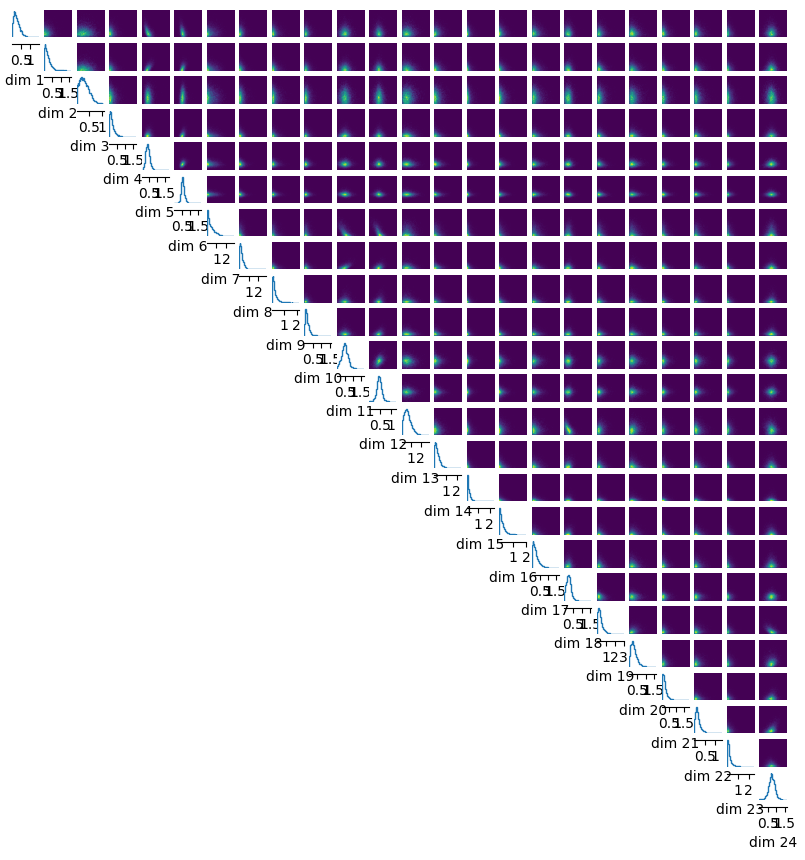

In [57]:
from sbi import analysis as analysis
x_o = []
for i in range(6):
    x_o = x_o + [e_act[i], pv_act[i], som_act[i], vip_act[i]]
x_o = torch.tensor(x_o).squeeze()

posterior_samples = posterior.sample((10000,), x=x_o)


In [74]:
points = torch.tensor([0.85019137, 0.12046141, 0.32576243, 0.        , 0.00194141,
       0.34042947, 0.6267717 , 0.        , 0.49034239, 0.        ,
       0.00383783, 0.37665983, 0.90247262, 0.        , 0.        ,
       0.51539458, 0.        , 0.3630127 , 0.61244814, 0.13455959,
       0.52075599, 0.        , 0.        , 0.64538931])

labels = []
cells = ['e', 'pv', 'som', 'vip']
for cell in cells:
    for j in range(4):
        labels.append(f'w_{cell}_{cells[j]}')
    labels.append(f'a_{cell}')
    labels.append(f'b_{cell}')
print(labels)


['w_e_e', 'w_e_pv', 'w_e_som', 'w_e_vip', 'a_e', 'b_e', 'w_pv_e', 'w_pv_pv', 'w_pv_som', 'w_pv_vip', 'a_pv', 'b_pv', 'w_som_e', 'w_som_pv', 'w_som_som', 'w_som_vip', 'a_som', 'b_som', 'w_vip_e', 'w_vip_pv', 'w_vip_som', 'w_vip_vip', 'a_vip', 'b_vip']


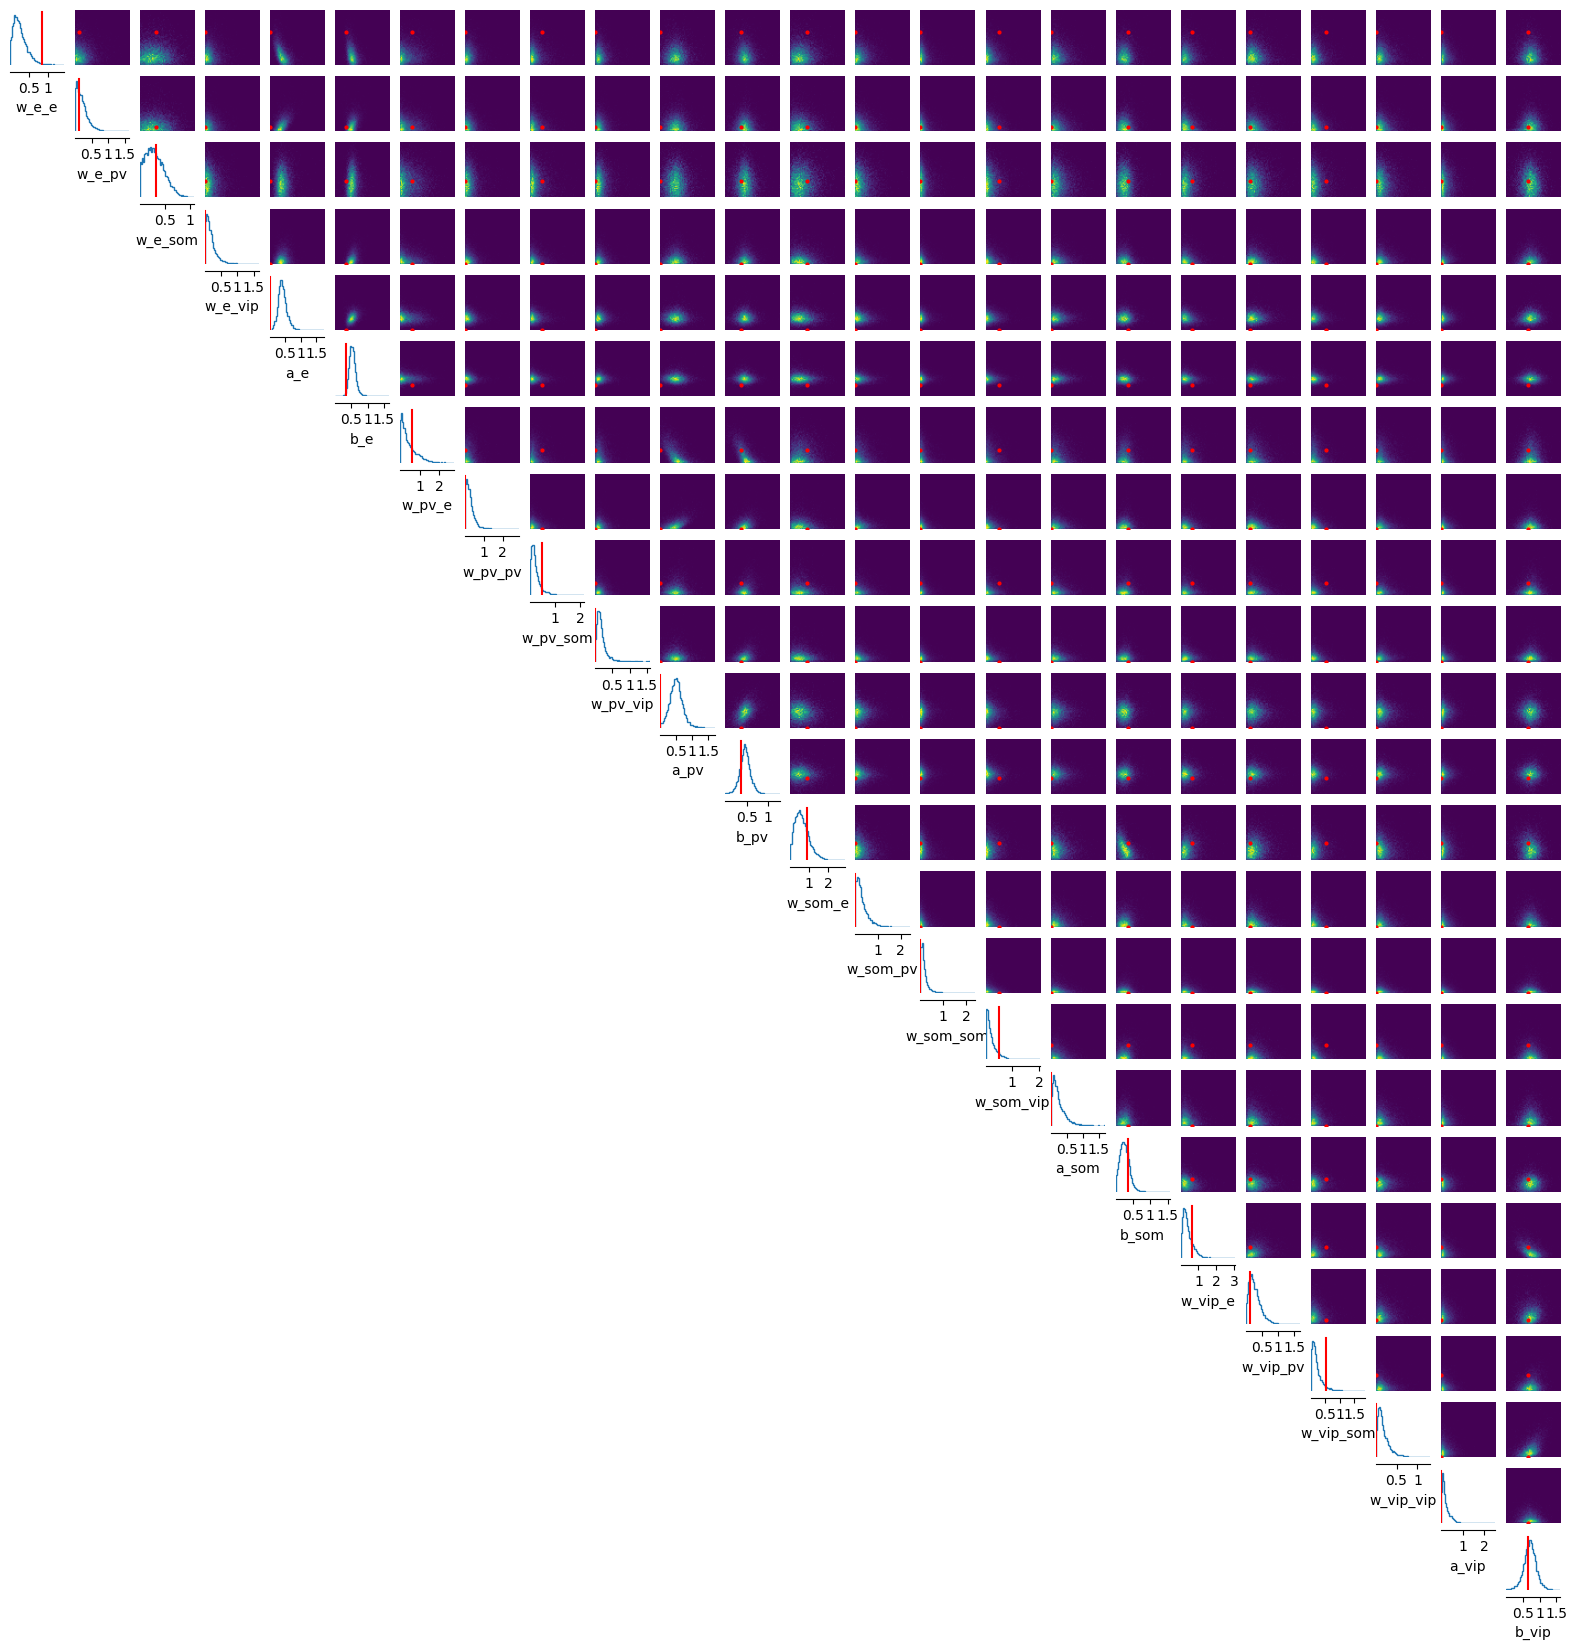

In [77]:

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples,
    figsize=(20, 20),
   points=points,
   points_offdiag={"markersize": 4},
   points_colors="r",
   labels=labels,
)

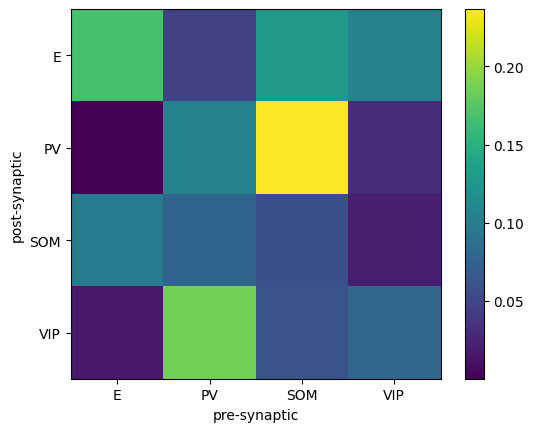

In [81]:
from scipy.stats import mode
from matplotlib import pyplot as plt

weights = mode(posterior_samples.numpy())[0]
weights = weights.reshape(4,6)
plt.imshow(weights[:,:4].T)
plt.xticks(np.arange(4), ['E', 'PV', 'SOM', 'VIP'])
plt.yticks(np.arange(4), ['E', 'PV', 'SOM', 'VIP'])
plt.xlabel('pre-synaptic')
plt.ylabel('post-synaptic')
plt.colorbar()

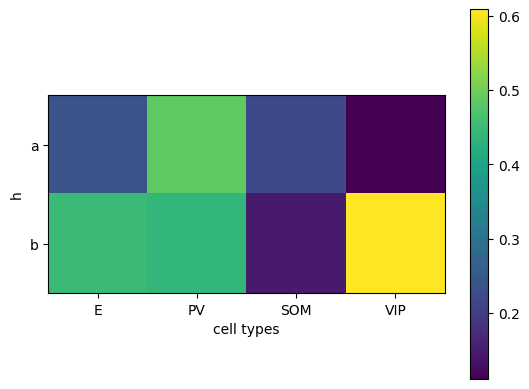

In [83]:
plt.imshow(weights[:,4:].T)
plt.xticks(np.arange(4), ['E', 'PV', 'SOM', 'VIP'])
plt.yticks(np.arange(2), ['a', 'b'])
plt.xlabel('cell types')
plt.ylabel('h')
plt.colorbar()

In [84]:
print(weights)

[[1.68029472e-01 5.93821733e-06 9.71259624e-02 1.64669976e-02
  2.40368173e-01 4.50391322e-01]
 [4.59207594e-02 1.05611317e-01 7.59070367e-02 1.86211720e-01
  4.84444112e-01 4.40420866e-01]
 [1.27283111e-01 2.36711696e-01 5.79502359e-02 6.19021878e-02
  2.20756844e-01 1.46883935e-01]
 [1.05437025e-01 3.03013567e-02 1.99659280e-02 7.79861808e-02
  1.11541934e-01 6.08478069e-01]]


In [86]:
#samples = posterior.sample((100,), x=x_o)
posterior_samples2 = posterior.sample((500,), x=x_o)
simulations = simulator(posterior_samples2)

Drawing 500 posterior samples: 646it [00:00, 796.53it/s]                         


104.0

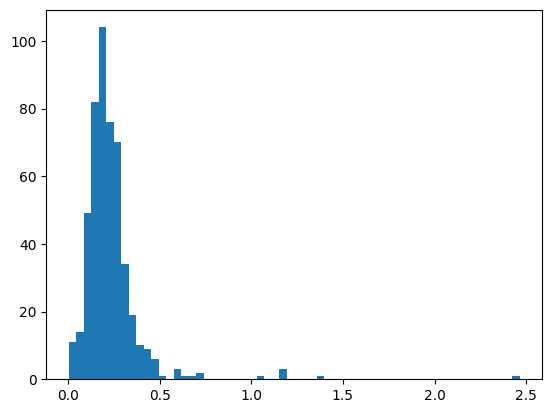

In [111]:
plt.hist(simulations[:,i], bins=60)[0].max()

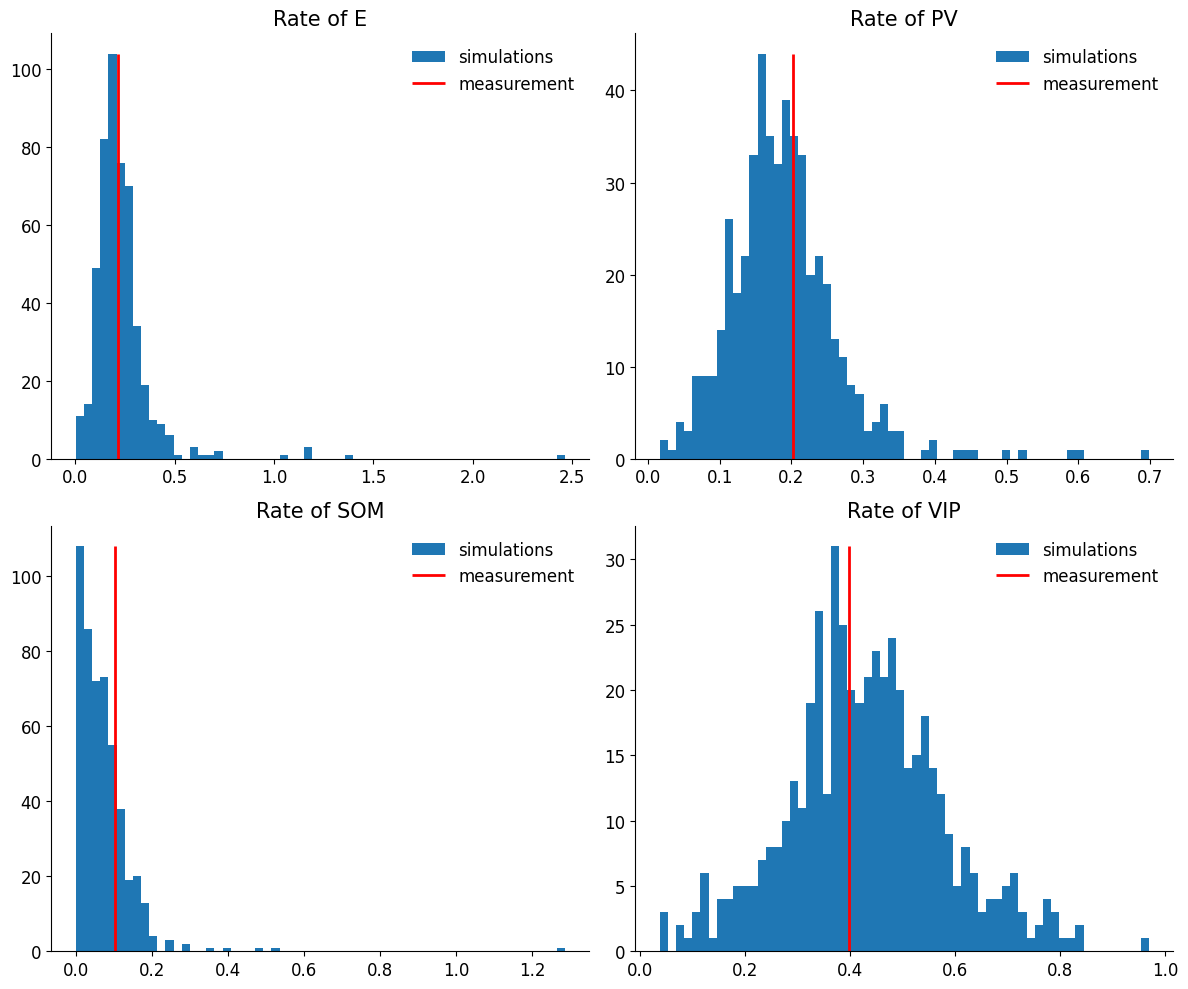

In [121]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Creates a 2x2 grid of subplots

# Titles for each subplot
cells = ['E', 'PV', 'SOM', 'VIP']

# Iterate over each subplot to plot the data
for i, ax in enumerate(axs.flat):
    ymax = ax.hist(simulations[:, i], bins=60, label='simulations')[0].max()
    ax.vlines(x_o[i], ymax=ymax, ymin=0, colors='r', label='measurement', linewidth=2)
    
    # Customize the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Increase the fontsize of the axis ticks
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(f'Rate of {cells[i]}', fontsize=15)
    ax.legend(fontsize=12, frameon=False)  # Remove the box from the legend

plt.tight_layout()
plt.show()

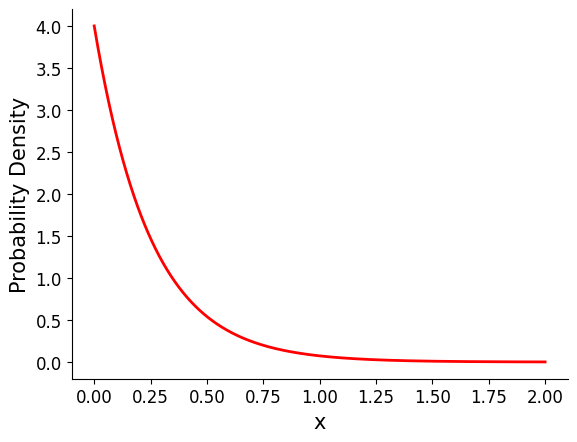

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lambda_val = 4

# Define the exponential distribution PDF
def exponential_pdf(x, lambda_val):
    return lambda_val * np.exp(-lambda_val * x)

# Generate x values
x = np.linspace(0, 2, 1000)

# Calculate the PDF values
y = exponential_pdf(x, lambda_val)

# Plot the PDF
plt.plot(x, y, 'r-', lw=2)

# Remove upper and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('x', fontsize=15)
plt.ylabel('Probability Density', fontsize = 15)

# Increase the fontsize of the axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)


plt.show()